In [1]:
import matplotlib.pyplot as plt
import dateutil.parser
import pandas as pd
import IPython
import numpy as np

db_columns=['timestamp','packetloss','tmin','tavg','tmax','tmdev']


In [2]:
fname='ping.bbc.co.uk.log'
print_raw=False
print_processed=False
print_errors=False


In [3]:
def readEntry(inputfile):
    pdf=pd.DataFrame(columns=db_columns) # create empty line in case if processing is not possible
    
    
    qline=inputfile.readline()
    if not qline:
        return ['eof',None]
    while not ('++++++' in qline):
        qline=inputfile.readline()
        if not qline:
            print('!!!!!!!')
            return ['eof',None]
    # now, i can either get a "===" or an empty line, in any case, read it out
    qpre_dateStr=inputfile.readline()
    if not qline:
            return ['eof',None]
    # the next line is the date
    qdateStr=inputfile.readline(); 
    if not qline:
            return ['eof',None]
    if print_raw:
        print('[date-raw] {}'.format(qdateStr))
    try:
        qdate=dateutil.parser.parse(qdateStr); 
    except Exception as e:
        if print_errors:
            print('----')
            print('[before] {}'.format(qpre_dateStr))
            print('[date-raw] {}'.format(qdateStr))
            qline=inputfile.readline() 
            if not qline:
                return ['eof',None]
            print('[then] {}'.format(qline))                                                    
            
        return ['error',None] # return empty line, try next line from the outer loop
        
    if print_processed:
            print('[date-parsed] {}'.format(qdate))
    
    # skip lines until the packets lost line
    qline=inputfile.readline()
    if not qline:
            return ['eof',None]
    while not ('packets transmitted' in qline):
        qline=inputfile.readline()
    if not qline:
            return ['eof',None]
    if print_raw: 
        print('[packetloss-raw] {}'.format(qline))
    #10 packets transmitted, 0 received, +10 errors, 100% packet loss, time 9013ms
    
    [q1, q2]=qline.split('%')
    packetloss=int(q1.split(',')[-1])
    
    if print_processed:
        print('[packetloss] {}%'.format(packetloss))
    
    stats_min=np.NAN; stats_avg=np.NAN;stats_max=np.NAN; stats_mdev=np.NAN
    if packetloss<100:
        # load in the stats line
        qline=inputfile.readline()
        if not qline:
            return ['eof',None]
        if print_raw: 
            print('[stats-raw] {}'.format(qline))
        [q1,q2]=qline.split('=')
        [q1,q2]=q2.split('ms')
        stats_strs=q1.split('/')
        stats_min=float(stats_strs[0])
        stats_avg=float(stats_strs[1])
        stats_max=float(stats_strs[2])
        stats_mdev=float(stats_strs[3])
        if print_processed:
            print('[stats] {:0.0f} / {:0.0f} / {:0.0f} / {:0.0f}'.format(stats_min,stats_avg,stats_max,stats_mdev))
            print('')

    pdf=pd.DataFrame([[qdate,packetloss,stats_min,stats_avg,stats_max,stats_mdev]], columns=db_columns)
    return ['ok',pdf]



In [4]:
txt='10 packets transmitted, 0 received, +10 errors, 100% packet loss, time 9013ms'
[q1, q2]=txt.split('%')
packetloss=int(q1.split(',')[-1])
packetloss

100

In [12]:
fname='ping.bbc.co.uk.log'

inputfile = open(fname)
db=pd.DataFrame(columns=db_columns)
# must initialize the db with a single read so that the data type gets initialized. It's ugly, i know
[subresult,db]=readEntry(inputfile)

#for idx in range(200):

fnames=['ping.bbc.co.uk.log','ping.uzdrowiciel.home.pl.log','ping.ping.online.net.log']
qmod=0;
for fname in fnames:
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> {}'.format(fname))
    inputfile = open(fname)

    while True:
        [subresult,new_entry] = readEntry(inputfile)
        if subresult=='ok':
            db=db.append(other=new_entry,ignore_index=True)    
        if subresult=='eof':
            break

        qmod+=1;
        if (qmod%500)==0:
            print(db['timestamp'][-1])


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ping.bbc.co.uk.log
2018-02-04 09:07:01+00:00
2018-02-04 17:45:01+00:00
2018-02-05 12:48:01+00:00
2018-02-05 20:58:02+00:00
2018-02-06 05:18:01+00:00
2018-02-06 13:54:01+00:00
2018-02-06 22:29:01+00:00
2018-02-07 06:49:01+00:00
2018-02-07 15:10:01+00:00
2018-02-07 23:32:01+00:00
2018-02-08 07:53:02+00:00
2018-02-08 16:13:01+00:00
2018-02-09 00:19:01+00:00
2018-02-09 10:10:01+00:00
2018-02-09 18:30:01+00:00
2018-02-10 02:50:02+00:00
2018-02-10 11:10:01+00:00
2018-02-10 19:33:01+00:00
2018-02-11 04:16:01+00:00
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ping.uzdrowiciel.home.pl.log
2018-02-03 14:15:13+00:00
2018-02-04 14:16:10+00:00
2018-02-05 09:20:19+00:00
2018-02-05 17:32:11+00:00
2018-02-06 01:52:11+00:00
2018-02-06 10:22:11+00:00
2018-02-06 20:23:10+00:00
2018-02-07 04:43:10+00:00
2018-02-07 13:03:11+00:00
2018-02-07 21:23:10+00:00
2018-02-08 05:47:10+00:00
2018-02-08 14:07:11+00:00
2018-02-09 03:05:11+00:00
2018-02-09 13:31:12+00:00
2018-02-09 2

KeyboardInterrupt: 

In [13]:
db.describe()

,packetloss,tmin,tavg,tmax,tmdev
count,28582.000000,27650.000000,27650.000000,2.765000e+04,27650.000000
mean,4.825764,548.813250,848.972936,1.191803e+03,215.088416
std,18.642651,1033.933204,2446.004798,1.042295e+04,4117.193902
min,0.000000,0.000000,41.190000,4.241000e+01,0.000000
25%,0.000000,59.233500,79.202750,1.009085e+02,10.698250
50%,0.000000,78.009000,139.774500,2.667960e+02,56.909000
75%,0.000000,525.983000,995.843500,1.364088e+03,231.665750
max,100.000000,8209.894000,343332.093000,1.706318e+06,681455.509000


In [14]:
db.timestamp[0]


Timestamp('2018-02-03 05:19:01+0000', tz='UTC')

In [15]:
pd.Timestamp('2018-02-01 00:00:01+0000', tz='UTC')

Timestamp('2018-02-01 00:00:01+0000', tz='UTC')

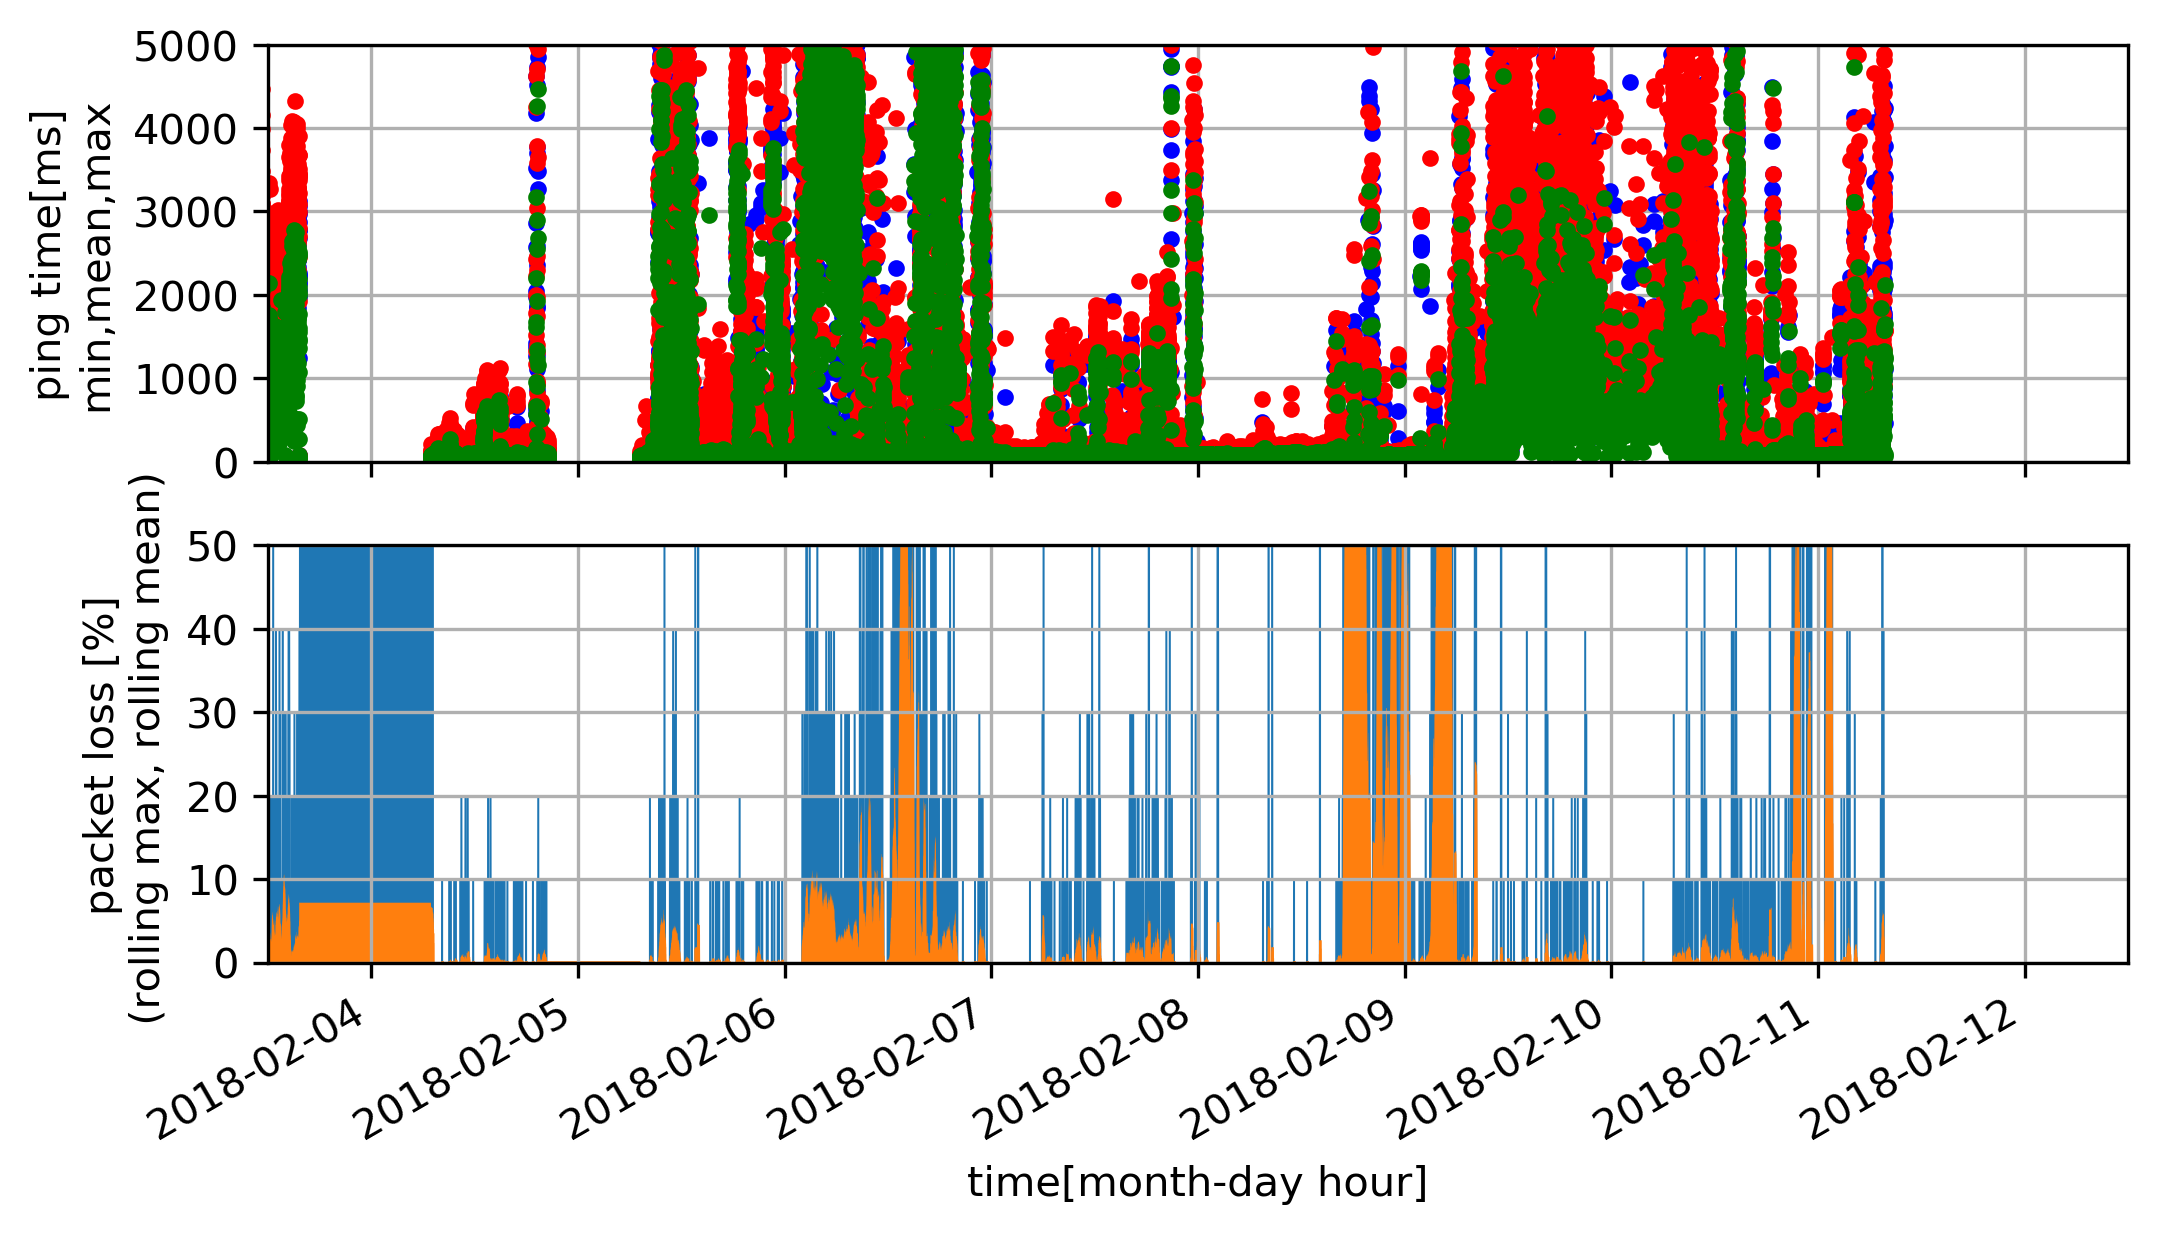

In [34]:

local_xlims=[pd.Timestamp('2018-02-03 12:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-12 12:00:00+0000', tz='UTC')]
def make_figure(local_xlims=[pd.Timestamp('2018-02-03 12:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-12 12:00:00+0000', tz='UTC')]):
    fig1=plt.figure(figsize=[8,4.5],dpi=300)
    ha1=plt.subplot(2,1,1)
    plt.plot(db['timestamp'],db['tavg'],'b.')
    plt.plot(db['timestamp'],db['tmax'],'r.')
    plt.plot(db['timestamp'],db['tmin'],'g.')
    fig1.autofmt_xdate()
    #plt.xlabel('time[month-day hour]')
    plt.ylabel('ping time[ms]\nmin,mean,max')
    plt.grid('on')
    plt.ylim([0,5000])
    plt.xlim(local_xlims)
    ax2=plt.subplot(2,1,2)

    #plt.plot(db['timestamp'],db['packetloss'],'r.')
    db_sorted=db.sort_values(by='timestamp')
    #db_sorted=db_sorted.where(db_sorted['packetloss']<80)
    r1=1
    r2=len(db)
    roll_range_max=15;
    roll_range_mean=60;


    tstamps=db_sorted['timestamp'].values[r1:r2]

    lv_high=db_sorted['packetloss'].rolling(roll_range_max).max().rolling(roll_range_max).max().rolling(roll_range_max).max().values[r1:r2]
    lv_mean=db_sorted['packetloss'].rolling(roll_range_mean).mean().values[r1:r2]

    z=np.zeros_like(lv_high)
    plt.fill_between(tstamps,z,lv_high)
    plt.fill_between(tstamps,z,lv_mean)


    plt.grid('on')
    fig1.autofmt_xdate()
    plt.xlabel('time[month-day hour]')
    plt.ylabel('packet loss [%]\n (rolling max, rolling mean)')
    plt.xlim(local_xlims)
    plt.ylim([0, 50]);
    return ha1


# entire time
local_xlims=[pd.Timestamp('2018-02-03 12:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-12 12:00:00+0000', tz='UTC')]
make_figure(local_xlims=[pd.Timestamp('2018-02-03 12:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-12 12:00:00+0000', tz='UTC')])
plt.savefig('ping_times_timeline.png')




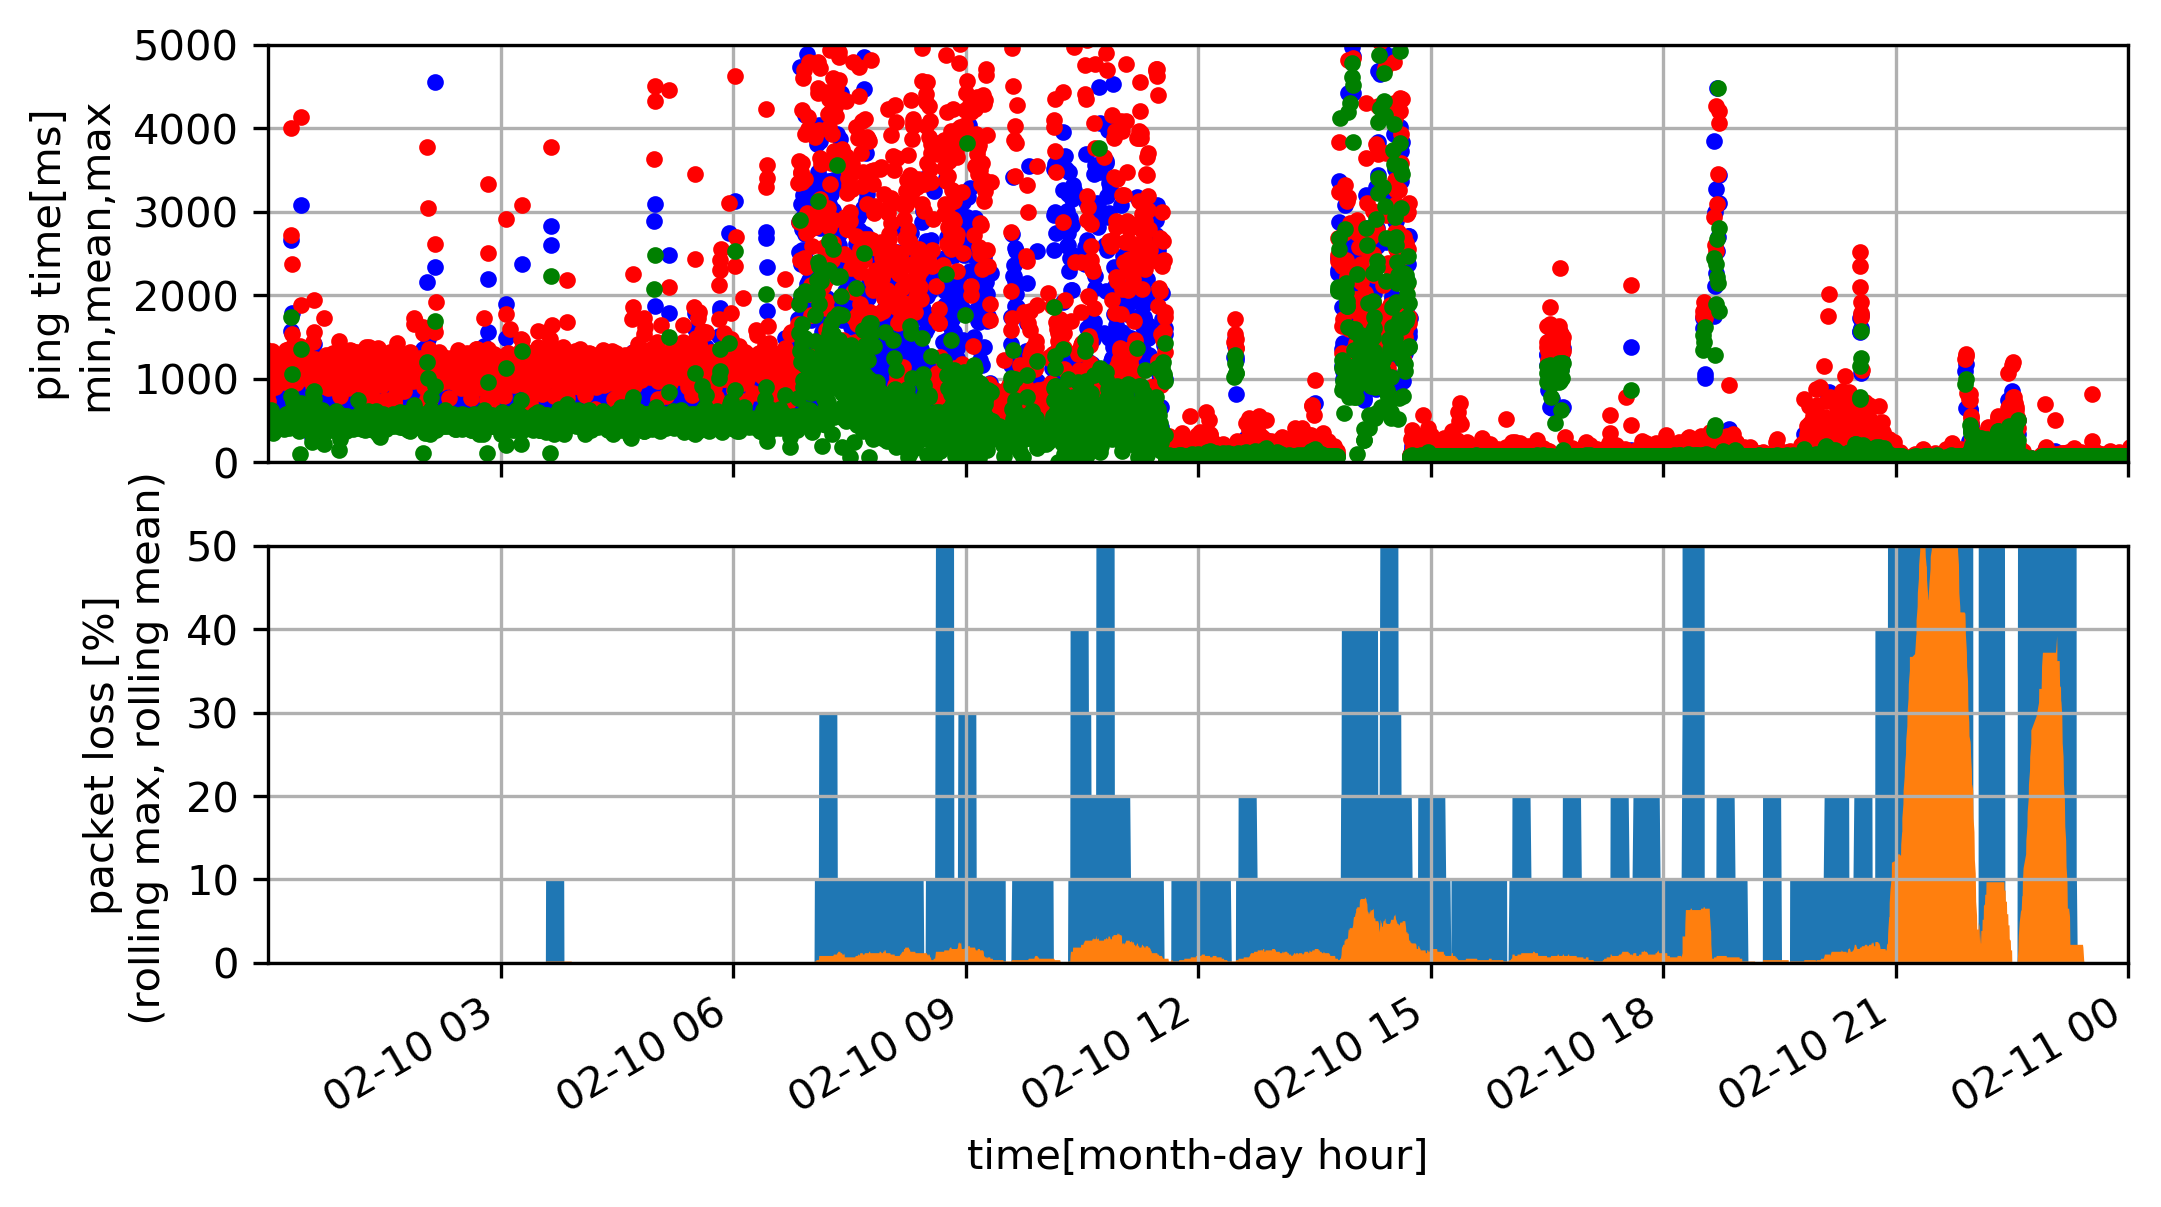

In [42]:
# Saturday
hf=make_figure(local_xlims=[pd.Timestamp('2018-02-10 00:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-11 00:00:00+0000', tz='UTC')])

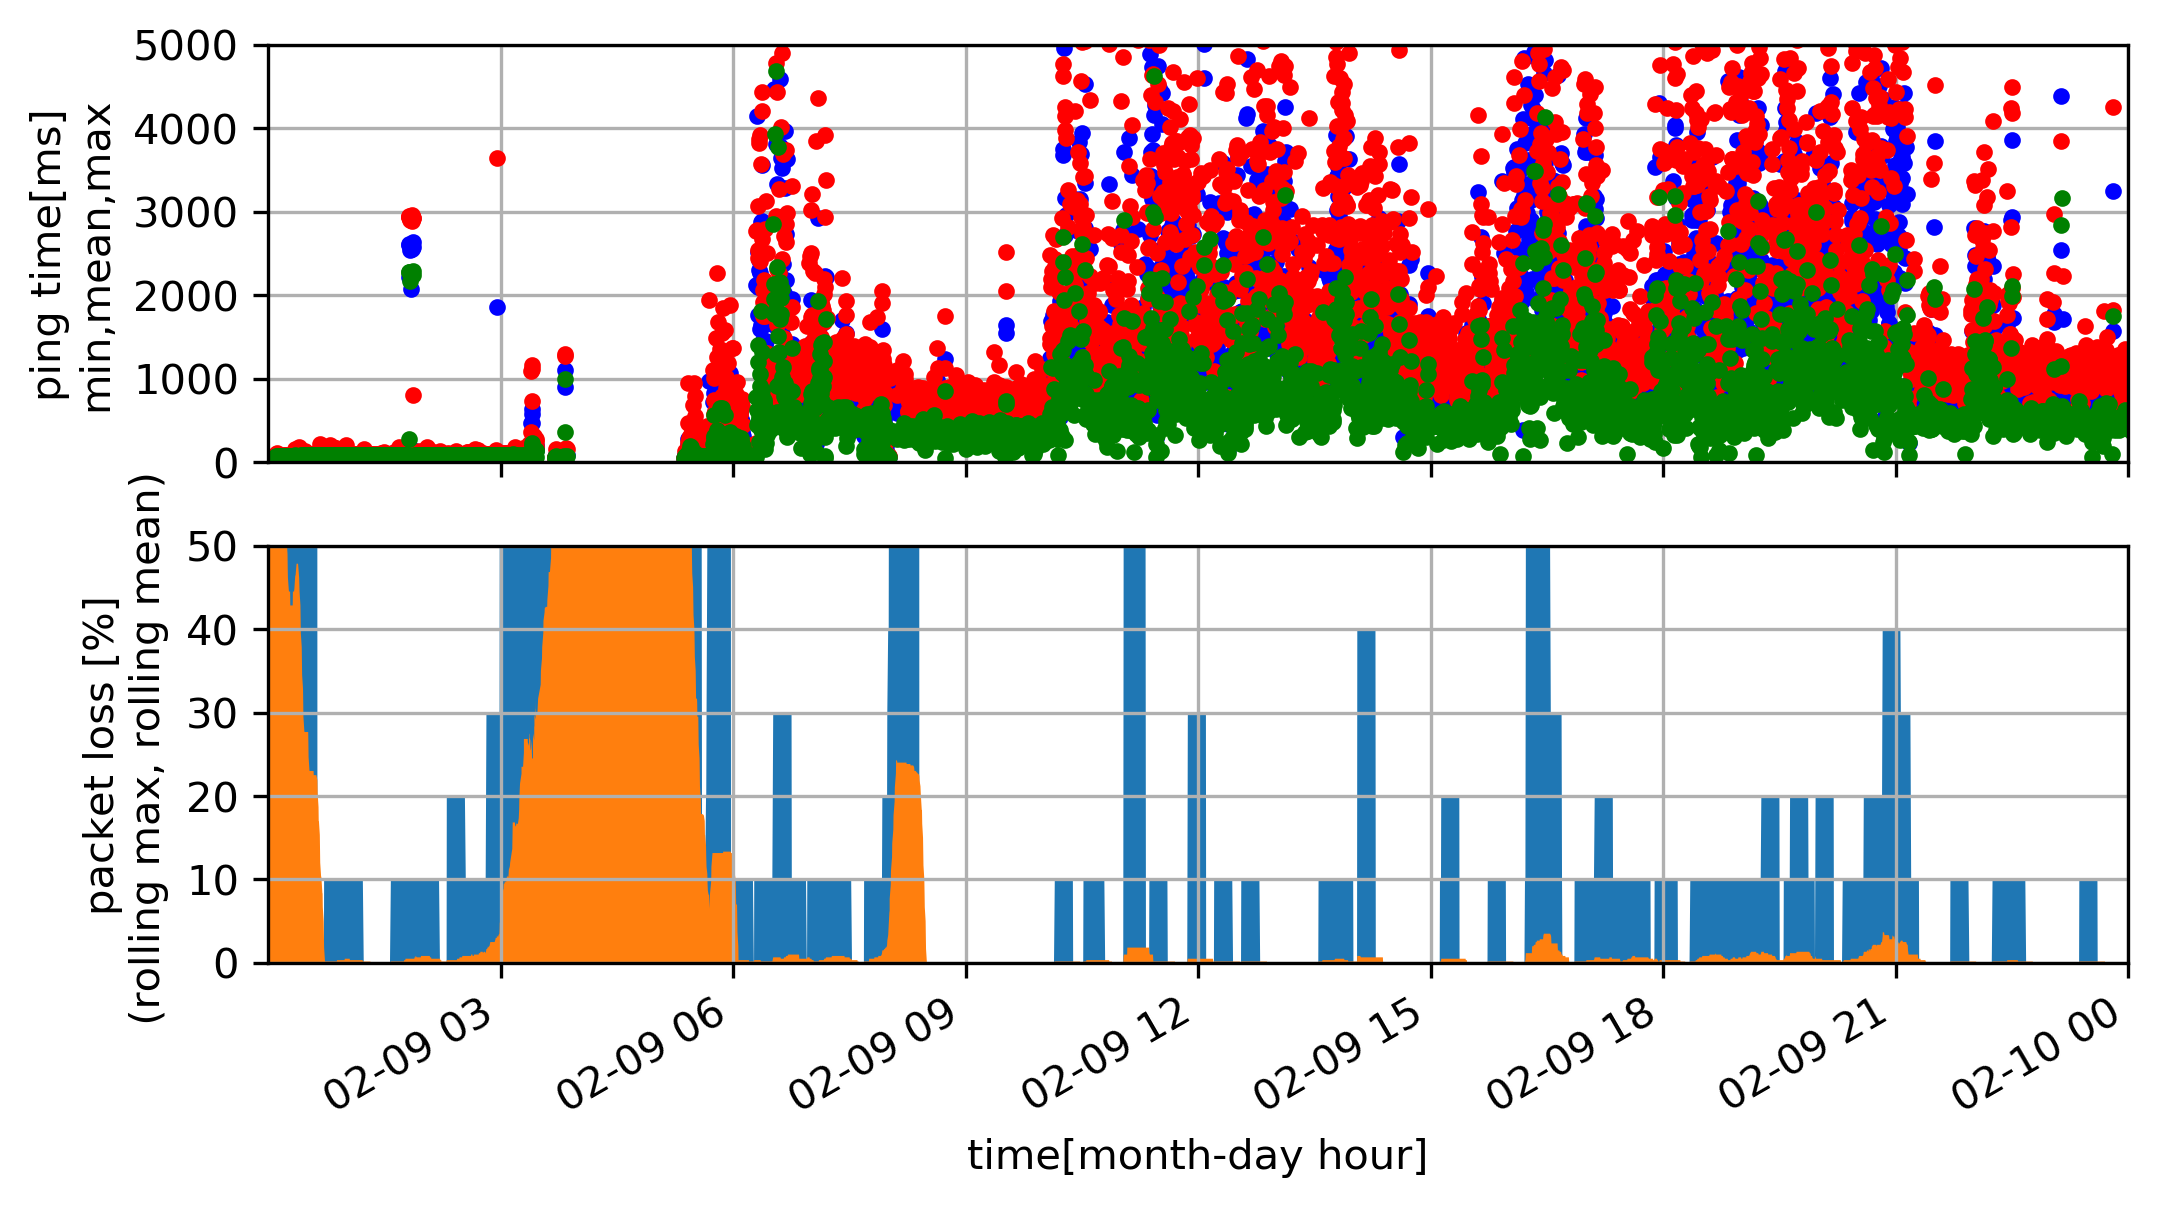

In [43]:
# friday
hf=make_figure(local_xlims=[pd.Timestamp('2018-02-09 00:00:01+0000', tz='UTC'),pd.Timestamp('2018-02-10 00:00:00+0000', tz='UTC')])

In [44]:
def fnq_less_100(q):
    return q<100

def fnq_100_200(q):
    return (q>=100)&(q<200)

def fnq_morethan_200(q):
    return (q>=200)
def fnq_morethan_1000(q):
    return (q>=1000)

ping_good=db['tmax'].map(fnq_less_100).sum()

ping_poor=db['tmax'].map(fnq_100_200).sum()
ping_bad=db['tmax'].map(fnq_morethan_200).sum()
ping_unusable=db['tmax'].map(fnq_morethan_1000).sum()
record_count=len(db)
summary_legend='good: <100ms; poor: >100ms <200ms; bad: >200ms, appaling: >1000ms ;'
summary_string='good: {:0.1f}%, poor: {:0.1f}%, bad: {:0.1f}%, appaling: {:0.1f}% over {} samples'.format(
    100*ping_good/record_count,
    100*ping_poor/record_count,
    100*ping_bad/record_count,
    100*ping_unusable/record_count,
    record_count*10)
print(summary_legend)
print(summary_string)

good: <100ms; poor: >100ms <200ms; bad: >200ms, appaling: >1000ms ;
good: 23.8%, poor: 21.0%, bad: 51.9%, appaling: 33.1% over 285820 samples


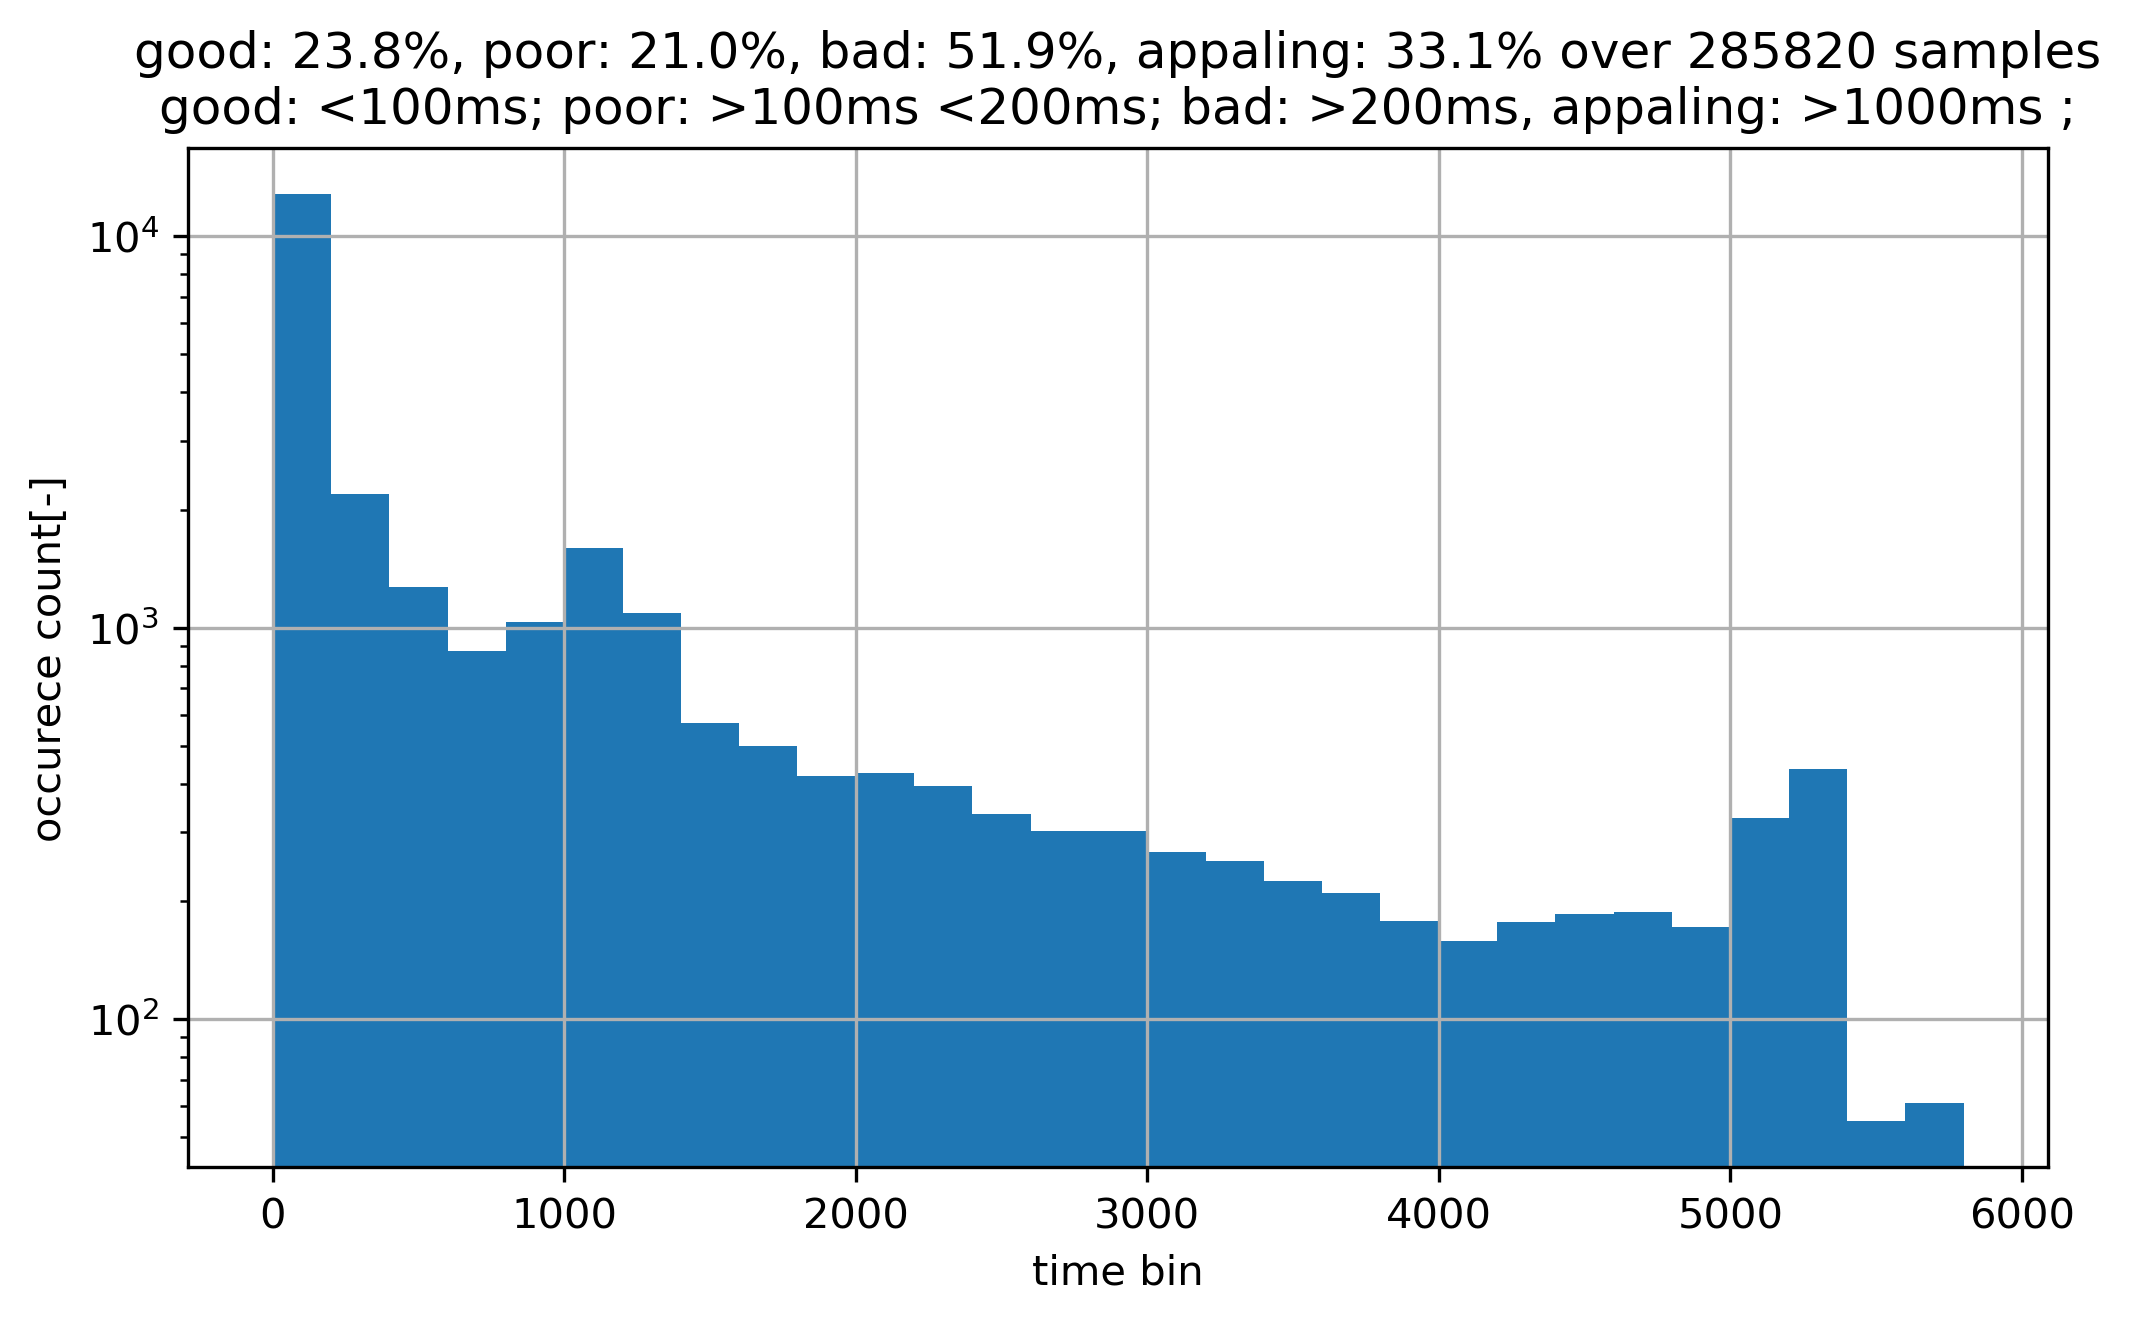

In [45]:
plt.figure(figsize=[8,4.5],dpi=300)
db['tmax'].plot.hist(bins=range(0,6000,200),stacked=True,log=True)
plt.grid('on')
plt.ylabel('occurece count[-]') 
plt.xlabel('time bin')
plt.title(summary_string+'\n'+summary_legend);
plt.savefig('ping_times_histogram.png')